### Evaluating the Effect of Time Bin Size on Learned Tunings calculate based on REM periods' firings
##### This Jupyter notebook explores the effect of time bin size on the learned tunings that are calculated based on neuronal population activity during REM periods. Specifically, we will investigate how the size of the time bin used for the analysis affects fidelity of the learned tunings to the correspondong place fields.

##### We will perform this analysis on a dataset of neural recordings from rats during REM sleep periods. We will use different time bin sizes to calculate the population vectors, and compare the resulting learned tunings to determine the optimal time bin size for this dataset.


In [9]:
import os
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from learned_tuning.learned_tuning import calculate_place_field_fidelity_of_learned_tuning, calculate_all_column_correlations

%matplotlib widget


def gausswindow(sigma, halfwidth):
    """
    Compute a Gaussian window function.

    Parameters
    ----------
    sigma : float
        Standard deviation of the Gaussian distribution.
    halfwidth : int
        Half the length of the window.

    Returns
    -------
    win : numpy.ndarray
        The Gaussian window function.

    """
    mu = 0
    x = np.arange(mu - halfwidth, mu + halfwidth + 1)
    y = np.zeros(x.shape)
    
    for i in range(len(x)):
        y[i] = (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-(x[i] - mu)**2 / (2*sigma**2))
    
    win = y/np.sum(y)
    
    return win


z_score = lambda x:(x-np.nanmean(x)) /np.std(x) # the function to calculate z-score
p_score = lambda x: 100 * np.sum(x <= x[i]) / len(x)

normalize_to_max = lambda x:(x/np.nanmax(x))


# load REM learned tunings calculated using MATLAB

main_dir = '/home/kouroshmaboudi/Documents/Learned_tuning_Python/Datasets/'
rr = os.listdir(main_dir)

current_sessions = [x for x in range(17) if x not in (12, 13)] # RatV sessions for now and Roy familiar sessions were excluded

epoch_names = ['pre', 'post']

bin_durations = [0.02, 0.05, 0.125, 0.25, 0.5, 1, 2] # bin sizes used for calculation of REM learned tunings


number_of_sessions = len(current_sessions)
num_units = np.empty((number_of_sessions,), dtype=int)
each_unit_session_number = np.empty((number_of_sessions,), dtype=object)

spatial_tunings_maze = np.empty((number_of_sessions,), dtype=object) # spatial tunings on MAZE


learned_tunings = np.empty((number_of_sessions,), dtype=object)
learned_tunings_place_field_corr = np.empty((number_of_sessions,), dtype=object)
learned_tunings_place_field_corr_unit_id_shuffle = np.empty((number_of_sessions,), dtype=object)

gw = gausswindow(3, 9) # for smoothing the tunings 


for session_idx in range(number_of_sessions):

    session_number = current_sessions[session_idx]
    session_name = rr[session_number]

    print(session_name + " " + str(session_idx+1) + "/" + str(number_of_sessions))

    session_dataset_path = os.path.join(main_dir, session_name)

    #--------------------------------------------------------------------------------------------
    # Load epochs information

    filename = f'{session_name}.fileInfo_for_python.mat'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = loadmat(file_path)
    session_info = mat_file["fileInfo"]

    epochs = session_info["behavior"][0][0][0][0]["time"]
    epoch_durations = epochs[:, 1] - epochs[:, 0]


    """
    spatial tunings during MAZE and reMAZE
    """

    spikes_pyr = loadmat(os.path.join(session_dataset_path, session_name + '.spikes_for_python.mat'))['spikes_pyr']
    
    if session_number in [6, 7]: # RatN and RatS
        num_units_total = spikes_pyr["spatialTuning_smoothed"].shape[0] # for RatN only
    else:
        num_units_total = spikes_pyr["spatialTuning_smoothed"][0].shape[0]

    num_pos_bins = spikes_pyr["spatialTuning_smoothed"][0][0]['uni'][0][0].size



    # Load unit stability information
    filename = f'{session_name}.cluster_quality_by_block'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = loadmat(file_path)
    cluster_quality_by_block = mat_file['cluster_quality_by_block'][0]


    
    spikes = []; # spike data and place field info of each unit

    # attributes = list(spikes_pyr.dtype.names) % if we want to work on all variable in the imported .mat data structure
    running_directions = {'LR', 'RL', 'uni'}
    other_attributes   = {'spike_times', 'shank_id','cluster_id'}

    iter = 0
    for unit in range(num_units_total):
        
        # Create dictionaries for each unit and store the matrices
        unit_spikes = dict()
        
        unit_spikes['place_fields_maze']  = {}
        unit_spikes['peak_pos_bins_maze'] = {}

        for direction in running_directions:
            try:
                if session_number in [6, 7]:    
                    unit_spikes['place_fields_maze'][direction] = spikes_pyr["spatialTuning_smoothed"][unit][0][direction][0][0].reshape(num_pos_bins) 
                    unit_spikes['peak_pos_bins_maze'][direction] = spikes_pyr['peakPosBin'][unit][0][direction][0][0][0][0]
                else:
                    unit_spikes['place_fields_maze'][direction] = spikes_pyr["spatialTuning_smoothed"][0][unit][direction][0][0].reshape(num_pos_bins) 
                    unit_spikes['peak_pos_bins_maze'][direction] = spikes_pyr['peakPosBin'][0][unit][direction][0][0][0][0]

            except ValueError:
                if iter == 0:
                    print("This session has only one running direction")
                iter += 1

        if session_number in [9, 10]: # for Rat V sessions
            unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
            unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][1] 
            unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][0]

        elif session_number in [6, 7]: # for RatN and RatS
            unit_spikes['spike_times'] = spikes_pyr['time'][unit][0] 
            unit_spikes['shank_id']    = spikes_pyr['id'][unit][0][0][0]-1
            unit_spikes['cluster_id']  = spikes_pyr['id'][unit][0][0][1]

        elif session_number == 8: # RatU  
            unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
            unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][0] # shank indices already starts at zero
            unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][1]

        else:
            unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
            unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][0]-1 # need to go one down for the other datasets
            unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][1]


        # Extract the cluster quality information by block for the current unit  
        curr_unit_idx = np.where(cluster_quality_by_block['cluster_ids'][unit_spikes['shank_id']] == unit_spikes['cluster_id'])[0]
        
        spike_amplitude_by_block = cluster_quality_by_block['spike_amplitude_by_block'][unit_spikes['shank_id']][curr_unit_idx]
        spike_amplitude_by_block = np.nan_to_num(spike_amplitude_by_block, nan=0)
        spike_amplitude_by_block_percent = spike_amplitude_by_block/cluster_quality_by_block['session_mean_spike_amplitude'][unit_spikes['shank_id']][curr_unit_idx]# as a percentage of session mean
        unit_spikes['spike_amplitude_by_block'] = spike_amplitude_by_block_percent

        firing_rate_by_block = cluster_quality_by_block['firing_rate_by_block'][unit_spikes['shank_id']][curr_unit_idx]
        firing_rate_by_block = np.nan_to_num(firing_rate_by_block, nan=0)
        # firing_rate_by_block_percent = firing_rate_by_block/cluster_quality_by_block['session_mean_firing_rate'][unit_spikes['shank_id']][curr_unit_idx]
        if firing_rate_by_block.shape[1] == 2: 
            sleep_firing_rate = (firing_rate_by_block[0][0]*epoch_durations[0] + firing_rate_by_block[0][1]*epoch_durations[2])/np.sum(epoch_durations[[0,2]])
        elif firing_rate_by_block.shape[1] == 3:
            sleep_firing_rate = (firing_rate_by_block[0][0]*epoch_durations[0] + firing_rate_by_block[0][1]*4*3600 + firing_rate_by_block[0][2]*(epoch_durations[2]-4*3600))/np.sum(epoch_durations[[0,2]])

        if sleep_firing_rate > 0:
            firing_rate_by_block_percent = firing_rate_by_block/sleep_firing_rate
        else:
            firing_rate_by_block_percent = np.zeros((firing_rate_by_block.shape[1], 1))

        unit_spikes['firing_rate_by_block'] = firing_rate_by_block_percent                

        isolation_distance_by_block = cluster_quality_by_block['isolation_distance_by_block'][unit_spikes['shank_id']][curr_unit_idx]
        isolation_distance_by_block = np.nan_to_num(isolation_distance_by_block, nan=0)
        unit_spikes['isolation_distance_by_block'] = isolation_distance_by_block


        unit_spikes['pre_post_unit_stability'] = (
            # (unit_spikes['spike_amplitude_by_block'][0][:2] > 0.9) & 
            (unit_spikes['firing_rate_by_block'][0][:2] > 0.33) & 
            (unit_spikes['isolation_distance_by_block'][0][:2] > 15)
        ).all()


        spikes.append(unit_spikes) 

    """
    MAZE spatial tunings / place fields
    """


    interp_pos_bins = np.linspace(0, num_pos_bins, 200)
    num_pos_bins_interp = len(interp_pos_bins)

    spatial_tunings_maze[session_idx] = np.zeros((num_units_total, num_pos_bins_interp))
    pre_post_unit_stability_curr_session = np.empty((num_units_total,))

    # peak_place_field_fr = np.full((num_units_total,), np.nan)

    for unit in range(len(spikes)):

        spatial_tuning_maze_curr_unit = spikes[unit]['place_fields_maze']['uni']
        # peak_place_field_fr[unit] = spikes[unit]['peak_firing_rate']['uni']

        spatial_tuning_maze_curr_unit = np.interp(interp_pos_bins, np.arange(1, num_pos_bins+1), spatial_tuning_maze_curr_unit)

        """
        Normalize the spatial tunings; zscoring (for multiple regression analysis), or set the max amplitude to one (for plotting the heatmaps)
        """
        spatial_tunings_maze[session_idx][unit] = spatial_tuning_maze_curr_unit

        # spatial_tunings_maze[session_idx][unit] = z_score(spatial_tuning_maze_curr_unit)
        # spatial_tunings_maze[session_idx][unit] = normalize_to_max(spatial_tuning_maze_curr_unit) 

        pre_post_unit_stability_curr_session[unit] = spikes[unit]['pre_post_unit_stability']


    active_units = np.where((np.nanmax(spatial_tunings_maze[session_idx], axis=1) > 1) & (pre_post_unit_stability_curr_session == True))[0]
    num_units[session_idx] = len(active_units)
    
    spatial_tunings_maze[session_idx] = np.apply_along_axis(normalize_to_max, 1, spatial_tunings_maze[session_idx])


    spatial_tunings_maze[session_idx] = spatial_tunings_maze[session_idx][active_units]
    spatial_tunings_maze[session_idx][np.isnan(spatial_tunings_maze[session_idx])] = 1e-16



    """
    Loading REM learned tunings using different bin sizes
    """
    learned_tunings_curr_session = dict()
    condition_names = []
    for i_bin, bin_dur in enumerate(bin_durations):
        mat_file = loadmat(os.path.join(session_dataset_path, 'NREM_REM_', session_name +  f".assemblyTunings_REM_{bin_dur:.3f}.mat"))
        for epoch in epoch_names:
            curr_conditions = f'{epoch}_{bin_dur:0.3f}'
            condition_names.append(curr_conditions)
            learned_tunings_curr_session[curr_conditions] = mat_file["assemblyTunings"][epoch].item()['data'].item()

    condition_names = np.sort(condition_names)

    learned_tunings[session_idx] = dict()
    learned_tunings_place_field_corr[session_idx] = dict()
    learned_tunings_place_field_corr_unit_id_shuffle[session_idx] = dict()
    num_shuffles = 10000
    for cond_idx, condition in enumerate(condition_names):

        learned_tunings[session_idx][condition] = np.full((num_units[session_idx].item(), num_pos_bins_interp), np.nan)

        for unit in range(num_units[session_idx].item()):
            curr_unit_learned_tuning = learned_tunings_curr_session[condition][active_units[unit]].reshape(num_pos_bins)
            curr_unit_learned_tuning = np.interp(interp_pos_bins, np.arange(1, num_pos_bins+1), curr_unit_learned_tuning)
            curr_unit_learned_tuning[np.isnan(curr_unit_learned_tuning)] = 0

            curr_unit_learned_tuning = np.convolve(curr_unit_learned_tuning, gw, mode='same')

            # Normalize
            # learned_tunings[session_idx][epoch_name][unit] = z_score(curr_unit_learned_tuning)
            learned_tunings[session_idx][condition][unit] = normalize_to_max(curr_unit_learned_tuning)

        # recalculate the correlation between learned tunings and MAZE place fields
        (learned_tunings_place_field_corr[session_idx][condition],
        learned_tunings_place_field_corr_unit_id_shuffle[session_idx][condition],
        _) = calculate_place_field_fidelity_of_learned_tuning(
                learned_tunings[session_idx][condition],
                spatial_tunings_maze[session_idx],
                num_shuffles
            )

    each_unit_session_number[session_idx] = np.full((num_units[session_idx],), session_number)



Achilles_10252013 1/15


/tmp/ipykernel_23017/3756029985.py:43: RuntimeWarning: invalid value encountered in divide
  normalize_to_max = lambda x:(x/np.nanmax(x))


Achilles_11012013 2/15
This session has only one running direction
Buddy_06272013 3/15
Cicero_09172014 4/15
Gatsby_08282013 5/15
This session has only one running direction
Kevin-maze1 6/15
RatN_Day2_2019-10-11_03-58-54 7/15


/home/kouroshmaboudi/miniconda3/envs/learned_tuning_project_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


RatS-Day2-2020-11-27_10-22-29 8/15
RatU_Day2NSD_2021-07-24_08-16-38 9/15
RatV_Day1NSD_2021-10-02_08-10-23 10/15
RatV_Day3NSD_2021-10-07_08-10-12 11/15
Roy-maze1 12/15
Ted-maze1 13/15
Ted-maze2 14/15
Ted-maze3 15/15


In [12]:
# concatenate place fields from all sessions and sort them according to the peak place field locations

spatial_tunings_maze_sessions_concat = np.concatenate(spatial_tunings_maze, axis=0)
place_fields_peak_locations = np.argmax(spatial_tunings_maze_sessions_concat, axis=1)
place_fields_sort_idx = np.argsort(place_fields_peak_locations)

spatial_tunings_maze_sessions_concat = spatial_tunings_maze_sessions_concat[place_fields_sort_idx]

# place_field_stability_maze_concat = np.concatenate(place_field_stability_maze, axis=0)
# place_field_stability_maze_concat = place_field_stability_maze_concat[place_fields_sort_idx]

each_unit_session_number_sessions_concat = np.concatenate(each_unit_session_number, axis=0)
each_unit_session_number_sessions_concat = each_unit_session_number_sessions_concat[place_fields_sort_idx]


# learned tunings
learned_tunings_sessions_concat = dict.fromkeys(condition_names)
learned_tunings_place_field_population_vector_correlation = dict.fromkeys(condition_names)
for condition in condition_names:
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(learned_tunings[session_idx][condition])
    learned_tunings_sessions_concat[condition] = np.concatenate(temp, axis = 0)
    learned_tunings_sessions_concat[condition] = learned_tunings_sessions_concat[condition][place_fields_sort_idx]

    # population vector correlation between the learned tunings and the place fields
    # learned_tunings_place_field_population_vector_correlation[condition] = calculate_all_column_correlations(learned_tunings_sessions_concat[condition], spatial_tunings_maze_sessions_concat)


learned_tunings_place_field_corr_sessions_concat = dict.fromkeys(condition_names)
learned_tunings_place_field_corr_unit_id_shuffle_concat = dict.fromkeys(condition_names)
learned_tunings_place_field_corr_p_values_concat = dict.fromkeys(condition_names)
lt_pf_correlation_median_across_all_sessions = dict.fromkeys(condition_names)
lt_pf_correlation_median_across_all_sessions_pvalue = dict.fromkeys(condition_names)

for condition in condition_names:
    # data
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(learned_tunings_place_field_corr[session_idx][condition])
    learned_tunings_place_field_corr_sessions_concat[condition] = np.concatenate(temp, axis = 0)[place_fields_sort_idx]
    # learned_tunings_place_field_corr_sessions_concat[condition] = learned_tunings_place_field_corr_sessions_concat[condition][place_fields_sort_idx]

    # shuffle
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(learned_tunings_place_field_corr_unit_id_shuffle[session_idx][condition])
    learned_tunings_place_field_corr_unit_id_shuffle_concat[condition] = np.concatenate(temp, axis = 0)[place_fields_sort_idx]
    # learned_tunings_place_field_corr_unit_id_shuffle_concat[condition] = learned_tunings_place_field_corr_unit_id_shuffle_concat[condition][place_fields_sort_idx]

    # calculate the p-values of place fidelities
    lt_pf_correlation_median_across_all_sessions[condition] = np.nanmedian(learned_tunings_place_field_corr_sessions_concat[condition])  
    ui_lt_pf_correlation_medians = np.nanmedian(learned_tunings_place_field_corr_unit_id_shuffle_concat[condition], axis = 0)

    lt_pf_correlation_median_across_all_sessions_pvalue[condition] = np.sum(ui_lt_pf_correlation_medians >= lt_pf_correlation_median_across_all_sessions[condition])/num_shuffles



/tmp/ipykernel_23017/61763533.py:127: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


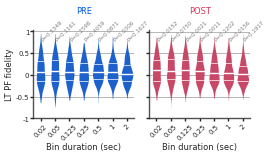

In [46]:
from matplotlib.gridspec import GridSpec
from matplotlib import ticker


def remove_trailing_zeros(x, _):
    if x == int(x):
        return str(int(x))
    else:
        return str(x)

def get_pval_statement(pvalue):
    if pvalue < 0.0001:
        pvalue_statement = 'P<1e-4'
    else:
        pvalue_statement = f'P={pvalue:.4f}'
    return pvalue_statement


# Define a function to plot violin plots
def plot_violin(ax, data, color):
    alpha = 1
    sns.violinplot(data=list(data.values()), ax=ax, color=color, inner='quartiles', linewidth=0, cut=0)
    for violin, curr_alpha in zip(ax.collections[::2], [alpha] * 5):
        violin.set_alpha(curr_alpha)
    for l in ax.lines:
        l.set_linestyle('-')
        l.set_linewidth(0.5)
        l.set_color('white')
        l.set_alpha(1)
    for l in ax.lines[1::3]:
        l.set_linestyle('-')
        l.set_linewidth(1)
        l.set_color('white')
        l.set_alpha(1)
    ax.set_xticklabels(bin_durations, rotation=45, ha='center')
    ax.grid(axis='y', color=(0.6, 0.6, 0.6), linewidth=0.5)
    for axis in ['left', 'bottom']:
        ax.spines[axis].set_linewidth(1)
        ax.spines[axis].set_alpha(0.8)



colors = [
    '#005CE9',  # PRE
    '#DD335D'  # POST
]


sns.set_style('whitegrid')
sns.set_context('paper')

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':6,
    'axes.linewidth':0.75,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':6,
    'axes.titlesize':6,
    'xtick.labelsize':5,
    'ytick.labelsize':5,
    'legend.fontsize':5,
    'legend.title_fontsize':5,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':2,
    'ytick.major.size':2
})



# Create figure and subplots
plotheight = 110
plotwidth = 200
font_size = 6

fig = plt.figure()
fig.set_size_inches([plotwidth/72, plotheight/72])
gs = GridSpec(nrows=1, ncols=2, figure=fig, wspace = 0.15)



# Split dictionary by epoch
pre_pf_fidelities_different_bin_sizes = {k: v for k, v in learned_tunings_place_field_corr_sessions_concat.items() if k.startswith('pre')}
pre_median_p_values_different_bin_sizes = {k:v for k, v in lt_pf_correlation_median_across_all_sessions_pvalue.items() if k.startswith('pre')}

post_pf_fidelities_different_bin_sizes = {k: v for k, v in learned_tunings_place_field_corr_sessions_concat.items() if k.startswith('post')}
post_median_p_values_different_bin_sizes = {k:v for k, v in lt_pf_correlation_median_across_all_sessions_pvalue.items() if k.startswith('post')}



# Plot distributions for pre-epoch conditions
ax0 = fig.add_subplot(gs[0])
plot_violin(ax0, pre_pf_fidelities_different_bin_sizes, colors[0])

# Add p-values for each violin
for i, (condition, data) in enumerate(pre_pf_fidelities_different_bin_sizes.items()):
    p_val = pre_median_p_values_different_bin_sizes[condition]
    ax0.text(i, 0.75 * ax0.get_ylim()[1], get_pval_statement(p_val), ha='left', fontsize=4, rotation=45, color='gray')

ax0.set_xlabel('Bin duration (sec)', labelpad = 1)
ax0.set_ylabel('LT PF fidelity', labelpad = 1)
ax0.set_title('PRE', color=colors[0], pad = 12)
ax0.tick_params(axis='both', which='major', labelsize=5, length=2, width=1, pad=1)
ax0.set_yticks(np.arange(-1,1.01,0.5))
ax0.yaxis.set_major_formatter(ticker.FuncFormatter(remove_trailing_zeros))


# Plot distributions for post-epoch conditions
ax1 = fig.add_subplot(gs[1])
plot_violin(ax1, post_pf_fidelities_different_bin_sizes, colors[1])

# Add p-values for each violin
for i, (condition, data) in enumerate(post_pf_fidelities_different_bin_sizes.items()):
    p_val = post_median_p_values_different_bin_sizes[condition]
    ax1.text(i, 0.75 * ax1.get_ylim()[1], get_pval_statement(p_val), ha='left', fontsize=4, rotation=45, color='gray')

ax1.set_xlabel('Bin duration (sec)', labelpad = 1)
ax1.set_title('POST', color=colors[1], pad = 12)
ax1.tick_params(axis='both', which='major', labelsize=5, length=2, width=1, pad=1)
ax1.set_yticks(np.arange(-1,1.01,0.5), [])


plt.subplots_adjust(left=0.12, right= 0.90, bottom=0.22, top=0.8)
plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
sns.despine()

filename = 'REM_learned_tunings_different_bin_sizes.pdf'
file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)
plt.show()
